In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from io import StringIO

# Principle component analysis

#### 1) Loading trajectory

We will compute PCA across all dimensions of all atoms, so we can reshape the timesteps, atoms, physical dimension shape into timesteps, all coordinates.

In [2]:
def load_traj(filename):
    if filename.split('.')[-1] == 'npy':
        return np.load('trajectory_calpha.npy')
    else:
        with open(filename, "r") as f:
            docu = f.read()
        frames = docu.split("128\n generated by VMD\n  ")[1:]
        
        columns_names = ['type', 'x', 'y', 'z']
        dfs = [pd.read_csv(StringIO(f), names=columns_names, delim_whitespace=True, header=None) for f in frames]
        arrays = [df[['x','y','z']].values for df in dfs]
    return np.stack(arrays)

In [3]:
traj = load_traj("trajectory_calpha.npy")
print(traj.shape)

# We are trying to find an optimal coordinate projection. Therefore, we can drop the cartesian structure.
traj = traj.reshape(traj.shape[0], -1)
print(traj.shape)

(3111, 128, 3)
(3111, 384)


#### 2) Mean-free trajectory

In [4]:
mean_free_traj = traj - np.mean(traj, axis=0)

#### 3) Covariance matrix

In [5]:
t_n = mean_free_traj.shape[0]
cov = (t_n - 1)**-1 * np.einsum('ij,ik', mean_free_traj, mean_free_traj)  # sum over rows, multiply columns
print(cov.shape)

(384, 384)


In [6]:
# compare to cov
print(np.all(np.isclose(np.cov(mean_free_traj, rowvar=False), cov)))

True


#### 4) Eingenvalues and eigenvectors

In [7]:
evals, evecs = np.linalg.eig(cov)

Text(0.5, 0, 'Eigenvalue rank')

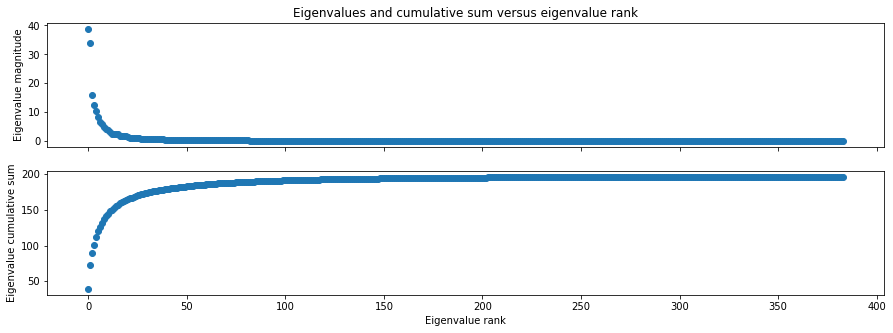

In [8]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(15,5))
ax[0].scatter(range(len(evals)), evals)
ax[1].scatter(range(len(evals)), np.cumsum(evals))

ax[0].set_title('Eigenvalues and cumulative sum versus eigenvalue rank')
ax[0].set_ylabel('Eigenvalue magnitude')
ax[1].set_ylabel('Eigenvalue cumulative sum')
ax[1].set_xlabel('Eigenvalue rank')

In [25]:
ok = evecs @ (evals * np.eye(evals.shape[0], evals.shape[0])) @ evecs.T

In [27]:
np.all(np.isclose(ok, cov))

True

#### 5) Projection

In [31]:
new = evecs.T @ mean_free_traj.T
new = new.T
print(new)

[[-5.65352487e+00  3.33564803e+00  3.91212018e+00 ... -2.39458322e-03
  -6.21762357e-03 -2.55733701e-02]
 [-6.61558205e+00  6.52870198e+00 -1.58970731e+00 ... -4.69092222e-02
  -2.72556546e-04 -3.45277011e-02]
 [-3.71071241e+00  1.83310844e+00  1.80819987e+00 ... -2.92317793e-02
   2.04789171e-02  1.08010291e-02]
 ...
 [ 5.64796264e-01  5.75675843e+00  1.18587857e+00 ...  3.93872193e-03
   3.51446930e-02  2.05442898e-04]
 [-8.64736250e+00 -1.34378538e+00  6.84498159e-01 ... -3.61808664e-02
   1.09236160e-02  4.20771955e-02]
 [-4.93221677e+00  3.27686695e-01  2.10506450e+00 ...  1.08336699e-02
  -6.79243707e-03 -3.47774826e-03]]


In [33]:
print(f"(time, space) = {new.shape}")

(time, space) = (3111, 384)


In [36]:
np.mean(new, axis=0)[:2]

array([-5.39820626e-13,  3.12410407e-13])

In [39]:
np.histogram2d(new[:, 0], new[:, 1])

(array([[  0.,   0.,   0.,   3.,  11.,   6.,   7.,   4.,   0.,   0.],
        [  0.,   0.,   9.,  23.,  32.,  37.,  46.,  29.,   9.,   0.],
        [  1.,  13.,  18.,  36.,  23.,  39.,  97.,  92.,  21.,   3.],
        [  0.,  10.,  19.,  13.,  21.,  66., 163., 125.,  22.,   2.],
        [  1.,   2.,   1.,   5.,  13.,  61., 111.,  71.,  40.,  10.],
        [  0.,   1.,   1.,   3.,  21.,  39.,  51.,  44.,  53.,  19.],
        [  1.,   4.,  14.,  15.,  43.,  84.,  74.,  98.,  89.,  15.],
        [  0.,  13.,  34.,  66.,  74.,  75.,  85., 241., 136.,   5.],
        [  1.,  13.,  35.,  51.,  37.,  23.,  74., 100.,  21.,   0.],
        [  0.,   5.,  11.,  10.,   4.,   4.,   7.,   2.,   0.,   0.]]),
 array([-15.20633476, -12.44087232,  -9.67540988,  -6.90994743,
         -4.14448499,  -1.37902254,   1.3864399 ,   4.15190234,
          6.91736479,   9.68282723,  12.44828968]),
 array([-20.42957744, -17.15473893, -13.87990042, -10.60506191,
         -7.3302234 ,  -4.05538489,  -0.78054638,   2.

#### 6) Visualization

In [12]:
mean_free_traj.shape

(3111, 384)

#### 7) Which molecular structure corresponds with the highest maximum?

In [42]:
PCA1_max = 0.5
PCA1_min = 0.1
PCA2_max = 0.7
PCA2_min = 0.3

times = []
for i, t in enumerate(new): 
    if PCA1_min < t[0] and t[0] < PCA1_max:
        if PCA2_min < t[1] and t[1] < PCA2_max:
            times.append([i, t])

In [43]:
times

[[501,
  array([ 3.45989679e-01,  4.45056145e-01,  1.07734188e+00, -3.50370438e+00,
         -8.56399551e-02, -1.05387750e-01,  8.08456515e-01, -3.63876270e+00,
         -1.66262974e-01,  3.14344965e-01,  9.31828046e-01, -3.55771761e+00,
         -1.91819832e-01, -2.14121351e+00,  7.71557524e-01, -2.84003897e-01,
          3.85960110e-01,  1.68359019e-01,  9.46920697e-01, -1.98044675e+00,
          1.86045805e+00, -1.20348288e-01, -1.56935940e+00,  9.25716793e-01,
         -3.67379254e-01,  5.19809046e-01,  7.05354259e-01, -7.86523933e-02,
         -1.41136543e-01,  2.98700746e-01,  8.57654714e-01,  6.15783219e-01,
         -9.58909268e-01,  1.87153181e-01, -1.00855271e-01, -3.77511242e-01,
          1.53440057e+00,  7.47655683e-01, -1.07189492e+00,  1.39858469e+00,
          1.13699881e+00,  4.90693153e-01,  8.36741429e-02, -3.67876024e-01,
          1.09517576e+00, -1.66090794e-01,  6.75983342e-02, -9.17051654e-01,
          5.50381258e-01, -4.24004040e-01,  1.55656360e-01,  4.343942

In [44]:
new.shape

(3111, 384)

In [45]:
new[501,:2]

array([0.34598968, 0.44505614])